Data Augmentation, Preventing Overfitting by using Dropout and regularization
================

Underfitting and Overfitting 
-------------

**Underfitting**  
  데이터의 개수가 부족한 경우  
데이터의 Bias가 너무 큰 경우   
충분한 학습이 부족한 경우    
데이터에 비해 모델이 너무 단순한 경우     
  
**Overfitting**  
데이터의 Variance가 높은 경우  
너무 많은 Epoch로 학습 데이터를 학습시킨 경우  
학습에 사용된 파라미터가 너무 많은 경우  
데이터에 비해 모델이 너무 복잡한 경우  
데이터에 노이즈 & Outlier가 너무 많은 경우  

**Dropout**  
드롭 아웃은 데이터를 학습할 때, 일부 뉴런을 랜덤하게 0으로 만들어 모델 내부의 특정 Weight에 치중되는 것을 막습니다.  
이를 통해 모델이 특정 데이터에 치중되는 것을 막고 일반화된 모델을 만들 수 있습니다.  
-> overfit 방지!!  


**l1 Regularization and l2 Regularization**  
L2 Loss 는 직관적으로 오차의 제곱을 더하기 때문에 Outlier 에 더 큰 영향을 받습니다.  
"L1 Loss 가 L2 Loss 에 비해 Outlier 에 대하여 더 Robust(덜 민감 혹은 둔감) 하다." 라고 표현 할 수 있습니다.  
Outlier 가 적당히 무시되길 원한다면 L1 Loss 를 사용하고, Outlier 의 등장에 신경써야 하는 경우라면 L2 Loss 를 사용하는 것이 좋겠습니다.  
L1 Loss 는 0인 지점에서 미분이 불가능하다는 단점 또한 가지고 있습니다.  
출처: https://light-tree.tistory.com/125 [잡탕찌개]  

```kernel_regularizer``` : Weight에 Regularization 적용  
```bias_regularizer``` : Bias에 Regularization 적용  
```activity_regularizer``` : Output y에 Regularization 적용  

**paramters**  
```data num``` : 지나치게 많으면 overfit 되겠지만 아래 모델에서는 최대 개수 25000개가 최대 성능을 냄    
```ouput num``` : 8개에서 train과 valid 점수가 가장 적어 최대 성능을 냄, 4개에서는 underfit됨  
```epochs``` : 20개에서 가장 좋은 성능을 냄, 그 이상에서는 overfit 됨  
```dropout``` : 수치를 올릴수록 underfit 되는 경향이 있으나 적절한 수치에서는 가장 좋은 성능을 냄  
```l1``` regularization : 수치를 올릴수록 성능이 떨어지나 overfit에서 벗어남  
```l2``` regularization : 수치를 올려도 성능이 유지되면서 overfit에서 벗어나는 모습을 보임 -> 이걸 조정하자!  

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 16)                1616      
_________________________________________________________________
dense_145 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 17        
Total params: 1,905
Trainable params: 1,905
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 16)                1616      
_________________________________________________________________
dense_148 (Dense)            (None, 16)                272       
____________________________

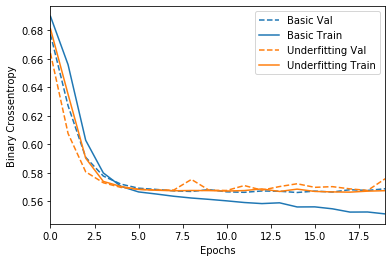

In [86]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import warnings

warnings.filterwarnings('ignore')


def sequences_shaping(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  
        
    return results


def Visualize(histories, key='binary_crossentropy'):

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    
    plt.savefig("pictures/underfit_25000_16_20_0005_plot.png")

word_num = 100
data_num = 25000
epochs = 20
output = 16
dropout = 0.8
l1 = 0.005
l2 = 0.005

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

train_data = train_data[:data_num,:]
test_data = test_data[:data_num,:]
train_labels = train_labels[:data_num]
test_labels =test_labels[:data_num]

basic_model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(word_num,),),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 과소적합 모델입니다.
underfitting_model = keras.Sequential([
    keras.layers.Dense(output, activation=tf.nn.relu, input_shape=(word_num,),kernel_regularizer= keras.regularizers.l2(l2)),
#     keras.layers.Dropout(dropout),
    keras.layers.Dense(output, activation=tf.nn.relu, kernel_regularizer= keras.regularizers.l2(l2)),
#     keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


basic_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
basic_model.summary()
baseline_history = basic_model.fit(train_data,train_labels,epochs=epochs,batch_size=500,validation_data=(test_data, test_labels), verbose=0)


underfitting_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
underfitting_model.summary()
underfitting_history = underfitting_model.fit(train_data, train_labels, epochs=epochs, batch_size=500, validation_data=(test_data, test_labels),verbose=0)


Visualize([('basic', baseline_history),('Underfitting', underfitting_history)])

output_num과 epoch_num에 따른 overfitting 여부 시각화(data_num 고정)
--------------------

<Figure size 2160x1080 with 0 Axes>

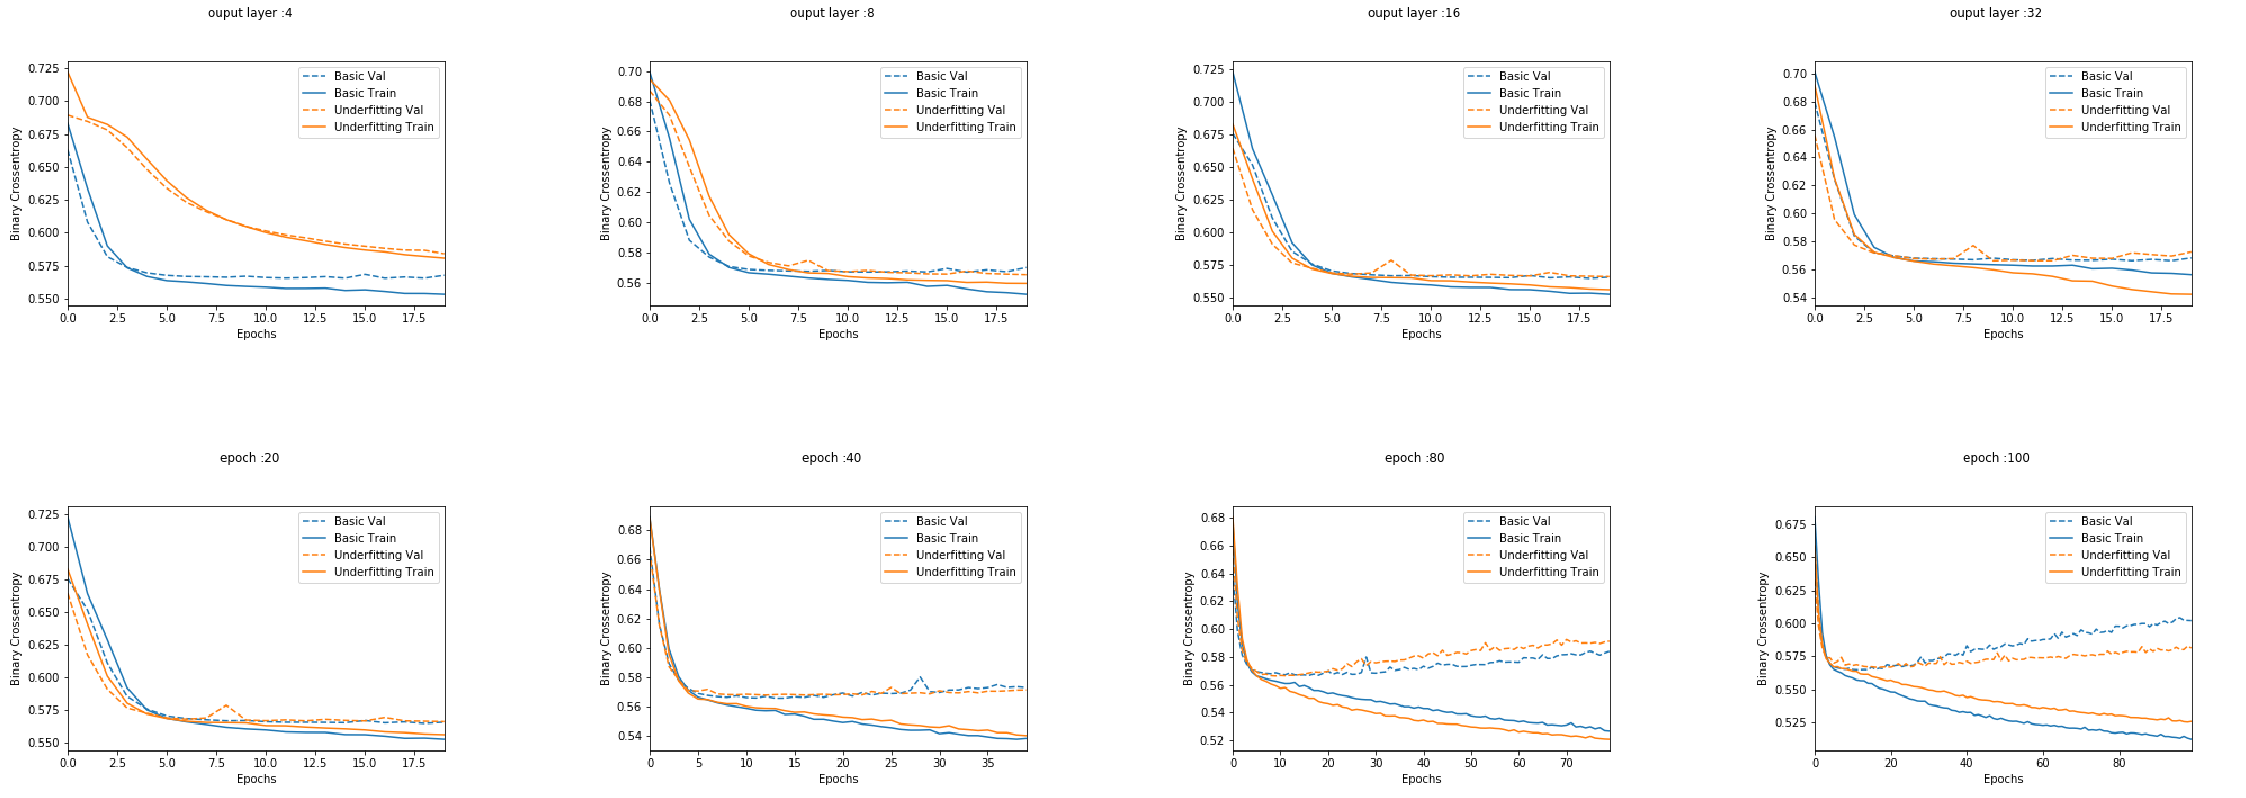

In [62]:
from matplotlib.image import imread

plt.figure(figsize=(30, 15))
ouput_numl = [4,8,16,32]
epoch_numl = [20,40,80,100]

# epoch 20으로 고정
plt.figure(figsize=(40,15))
for i in range(len(ouput_numl)):
    plt.subplot((str(24) + str(i+1)))
    img = imread('pictures/underfit_25000_' + str(ouput_numl[i]) + '_20_plot.png')
    plt.axis('off')
    plt.imshow(img)
    plt.title('ouput layer :' + str(ouput_numl[i]))

# output_num 16으로 고정
for i in range(len(epoch_numl)):
    plt.subplot((str(24) + str(i+5)))
    img = imread('pictures/underfit_25000_16_' + str(epoch_numl[i]) + '_plot.png')
    plt.axis('off')
    plt.imshow(img)
    plt.title('epoch :' + str(epoch_numl[i]))

Data num에 따른 overfitting여부 시각화(output_num, epoch 고정)
-----------------

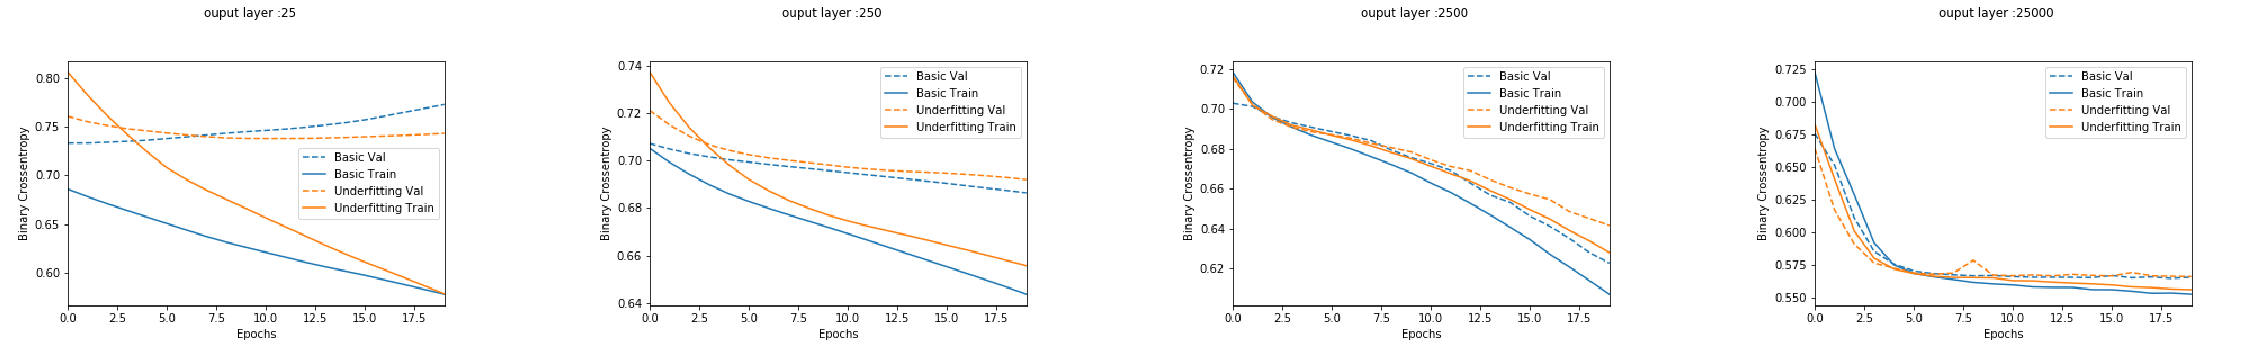

In [70]:
# output_num = 16, epoch = 20으로 고정
data_numl = [25,250,2500,25000]
plt.figure(figsize=(40,15))

for i in range(len(data_numl)):
    plt.subplot((str(14) + str(i+1)))
    img = imread('pictures/underfit_' + str(data_numl[i]) + '_16_20_plot.png')
    plt.axis('off')
    plt.imshow(img)
    plt.title('ouput layer :' + str(data_numl[i]))

Dropout에 따른 overfitting여부 시각화
------

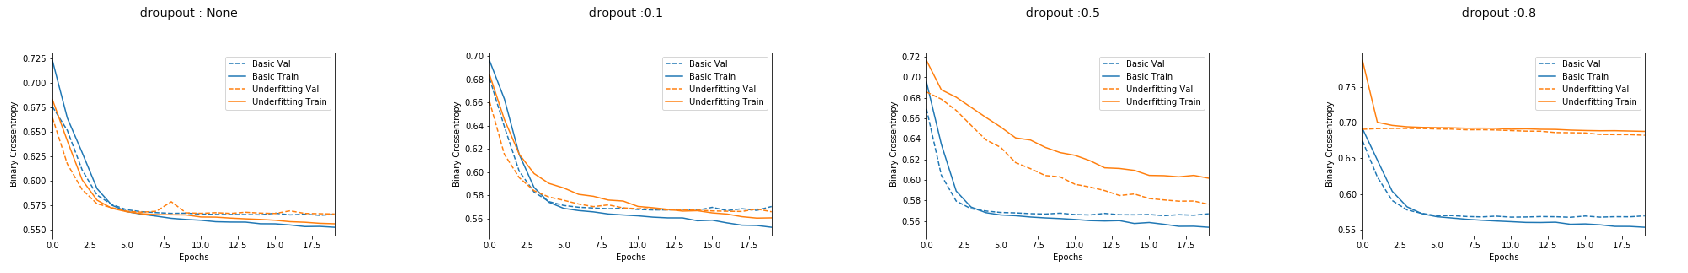

In [78]:
dropout_numl = [0.1, 0.5, 0.8]

plt.figure(figsize=(30, 15))
plt.subplot(141)
img = imread('pictures/underfit_25000_16_20_plot.png')
plt.axis('off')
plt.imshow(img)
plt.title('droupout : None')

for i in range(len(dropout_numl)):
    plt.subplot((str(14) + str(i+2)))
    img = imread('pictures/underfit_25000_16_20_' + str(dropout_numl[i])[0] + str(dropout_numl[i])[2] +'_plot.png')
    plt.axis('off')
    plt.imshow(img)
    plt.title('dropout :' + str(dropout_numl[i]))

L1 Regularization에 따른 overfitting 여부 시각화
-----------

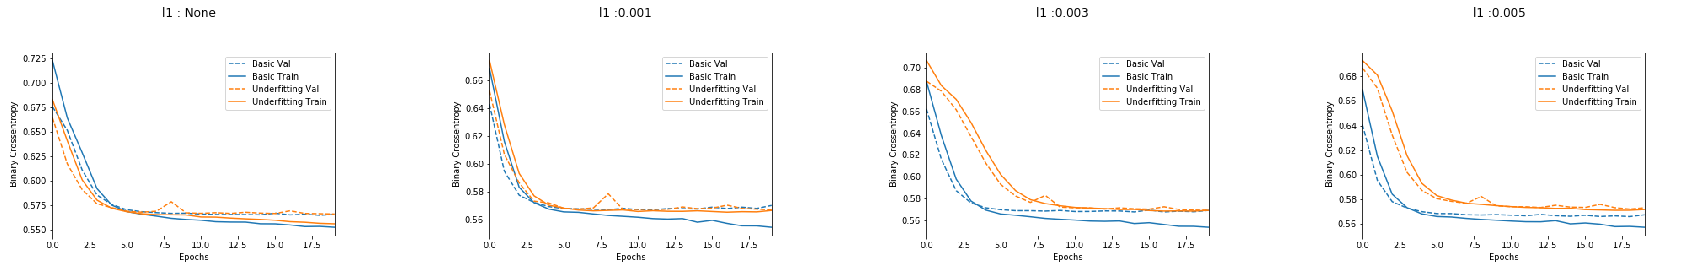

In [83]:
l1_numl = [0.001, 0.003, 0.005]

plt.figure(figsize=(30, 15))
plt.subplot(141)
img = imread('pictures/underfit_25000_16_20_plot.png')
plt.axis('off')
plt.imshow(img)
plt.title('l1 : None')

for i in range(len(l1_numl)):
    plt.subplot((str(14) + str(i+2)))
    img = imread('pictures/underfit_25000_16_20_' + str(l1_numl[i])[0] + str(l1_numl[i])[2:] +'_plot.png')
    plt.axis('off')
    plt.imshow(img)
    plt.title('l1 :' + str(l1_numl[i]))

l2 Regularization에 따른 overfitting 여부 시각화
----------

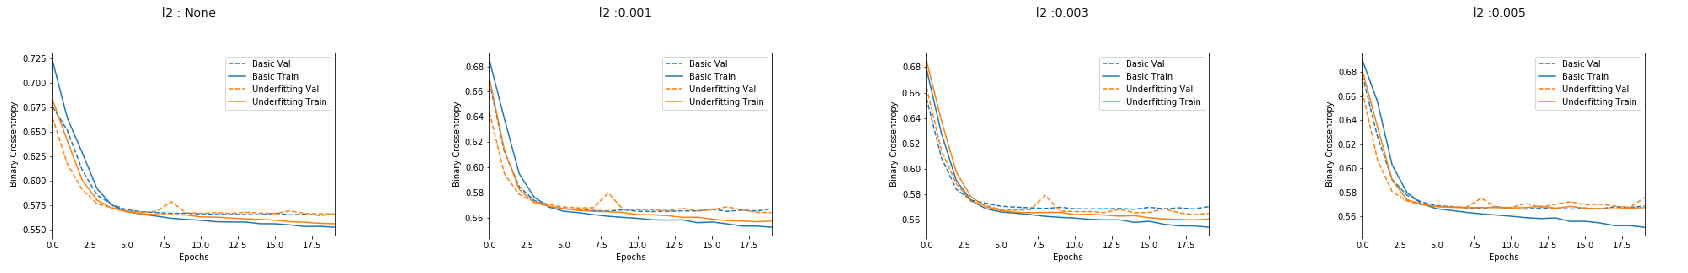

In [87]:
l2_numl = [0.001, 0.003, 0.005]

plt.figure(figsize=(30, 15))
plt.subplot(141)
img = imread('pictures/underfit_25000_16_20_plot.png')
plt.axis('off')
plt.imshow(img)
plt.title('l2 : None')

for i in range(len(l1_numl)):
    plt.subplot((str(14) + str(i+2)))
    img = imread('pictures/underfit_25000_16_20_' + str(l2_numl[i])[0] + str(l2_numl[i])[2:] +'_plot.png')
    plt.axis('off')
    plt.imshow(img)
    plt.title('l2 :' + str(l2_numl[i]))